# NAFNet GAN to denoise images

This is my implementation trained on an AMD Ryzen 7 5800X / 32GB RAM / RTX 5060 Ti 16GB

### Step 0: Import all the libraries and codes necessary to execute the model

In [1]:
# Python imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

# Code imports
from dataloader import DenoisingDataset2D
from models import NAFNet, Discriminator
from losses import CycleGANLoss

### Step 1: Define paths to load the images.

The dataset has images that are between 64x64 and 1024x1024. By default, the cropping was set to 64. If you want to tweak the cropping, just change the parameter 'crop_size'. Note that this will only be used on train and not on validation.

In [2]:
def plot_images(noisy, pred, target, epoch, save_dir="training_visuals"):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    titles = ["Noisy Input", "Denoised Output", "Ground Truth"]
    for i, img in enumerate([noisy, pred, target]):
        img = img.squeeze().cpu().numpy()  # Shape: (H, W)
        img = np.clip(img, 0, 1)
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, f"epoch_{epoch}_viz.png"))
    plt.close()  # Close the plot to free memory

def load_data(noisy_dir, gt_dir, test_size, batch_size, num_workers_tr, num_workers_val, crop_size = None):
    all_noisy = sorted([os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir) if f.endswith('.tif')])
    all_gt = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith('.tif')])

    if not all_noisy or not all_gt:
        raise ValueError("No .tif images found in the specified directories.")

    print(f"Found {len(all_noisy)} noisy images and {len(all_gt)} ground truth images.")

    train_noisy, val_noisy, train_gt, val_gt = train_test_split(all_noisy, all_gt, test_size=test_size, random_state=42)
    print(f"{len(train_noisy)} training images and {len(val_noisy)} validation images after split.")

    train_ds = DenoisingDataset2D(train_noisy, train_gt, crop_size=crop_size, augment=True)
    val_ds = DenoisingDataset2D(val_noisy, val_gt, crop_size=crop_size, augment=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers_tr, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=num_workers_val, pin_memory=True) # batch_size = 1

    print(f"\nTraining DataLoader created with {len(train_loader)} batches.")
    print(f"Validation DataLoader created with {len(val_loader)} batches.")

    return train_loader, val_loader

# Define data paths (update these to your actual paths)
noisy_dir = r"E:\PHD\phd_env\Proyectos\Denoising_challenge\Challenge 4\Data\Data\noisy"
gt_dir = r"E:\PHD\phd_env\Proyectos\Denoising_challenge\Challenge 4\Data\Data\gt"
pretrained_path = "NAFNet_GAN_best_model.pth"  # If it does not exist, then it will not load the weights on train.
checkpoint_path = "NAFNet_GAN_best_model.pth"
crop_size = 128
num_workers_tr = 6 # Number of workers for training 
num_workers_val = 6 # Number of workers for validation 

# Step 1: Load data
if os.path.exists(noisy_dir) == True and os.path.exists(gt_dir) == True:
    train_loader, val_loader = load_data(
        noisy_dir=noisy_dir,
        gt_dir=gt_dir,
        test_size=0.04,
        batch_size=48,
        num_workers_tr=num_workers_tr,  
        num_workers_val=num_workers_val,  
        crop_size=crop_size
    )

Found 63669 noisy images and 63669 ground truth images.
61122 training images and 2547 validation images after split.

Training DataLoader created with 1274 batches.
Validation DataLoader created with 2547 batches.


### Step 2: Visualize the dataloaders.

Visualizing training data sample:
Time to load first batch: 13.5454 seconds
Noisy batch shape: torch.Size([48, 1, 128, 128]), GT batch shape: torch.Size([48, 1, 128, 128])


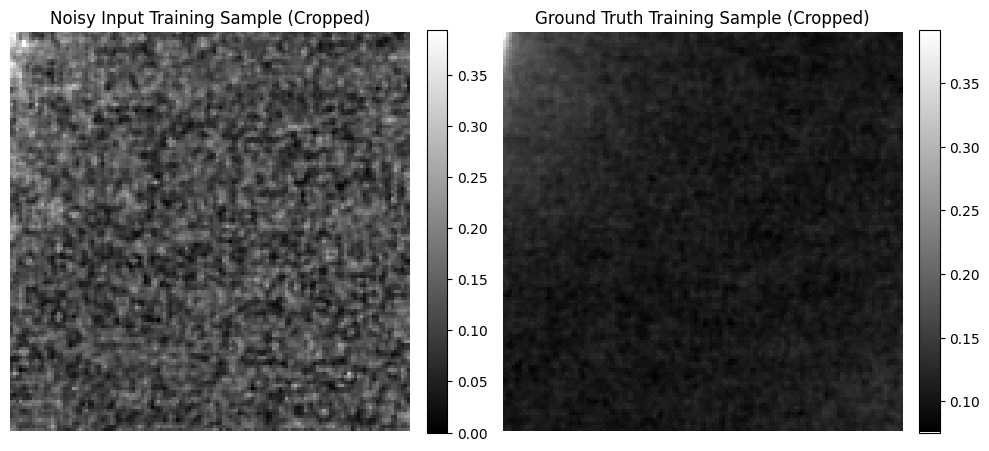

Visualizing validation data sample:
Time to load first batch: 11.8651 seconds
Noisy batch shape: torch.Size([1, 1, 512, 512]), GT batch shape: torch.Size([1, 1, 512, 512])


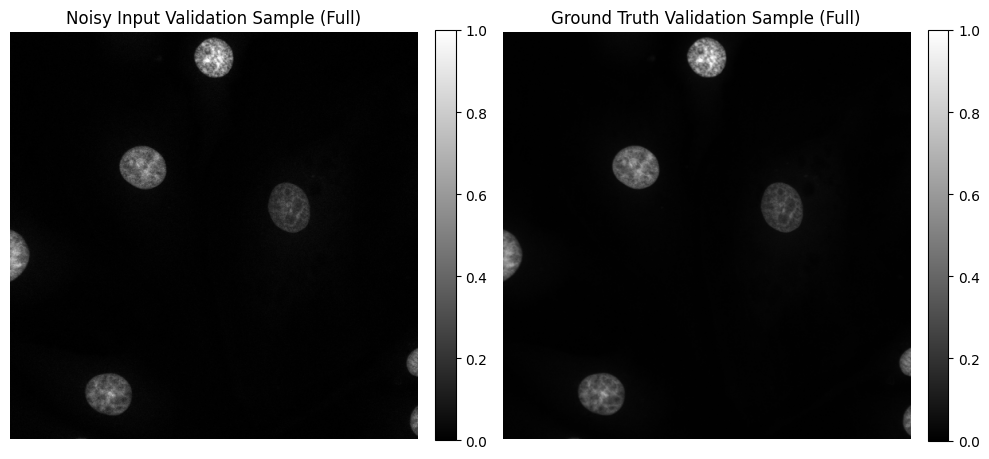

In [3]:
# Step 2: Visualize a sample from training and validation data
def visualize_dataloader(loader, title="Sample"):
    start_time = time.perf_counter()
    noisy_img_batch, gt_img_batch = next(iter(loader))
    end_time = time.perf_counter()
    print(f"Time to load first batch: {end_time - start_time:.4f} seconds")
    print(f"Noisy batch shape: {noisy_img_batch.shape}, GT batch shape: {gt_img_batch.shape}")

    noisy_sample = noisy_img_batch[0].squeeze().cpu().numpy()
    gt_sample = gt_img_batch[0].squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im0 = axs[0].imshow(noisy_sample, cmap='gray')
    axs[0].set_title(f"Noisy Input {title}")
    axs[0].axis("off")
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    im1 = axs[1].imshow(gt_sample, cmap='gray')
    axs[1].set_title(f"Ground Truth {title}")
    axs[1].axis("off")
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

print("Visualizing training data sample:")
visualize_dataloader(train_loader, title="Training Sample (Cropped)")

print("Visualizing validation data sample:")
visualize_dataloader(val_loader, title="Validation Sample (Full)")

### Step 3: Train the model.

Note that we have only trained it for 1 epoch.

Using device: cuda
Loaded pretrained weights from NAFNet_GAN_best_model.pth


Epoch 1/2 [Valid]: 100%|███████████████████████████████████████████████████████████| 2547/2547 [02:29<00:00, 17.04it/s]


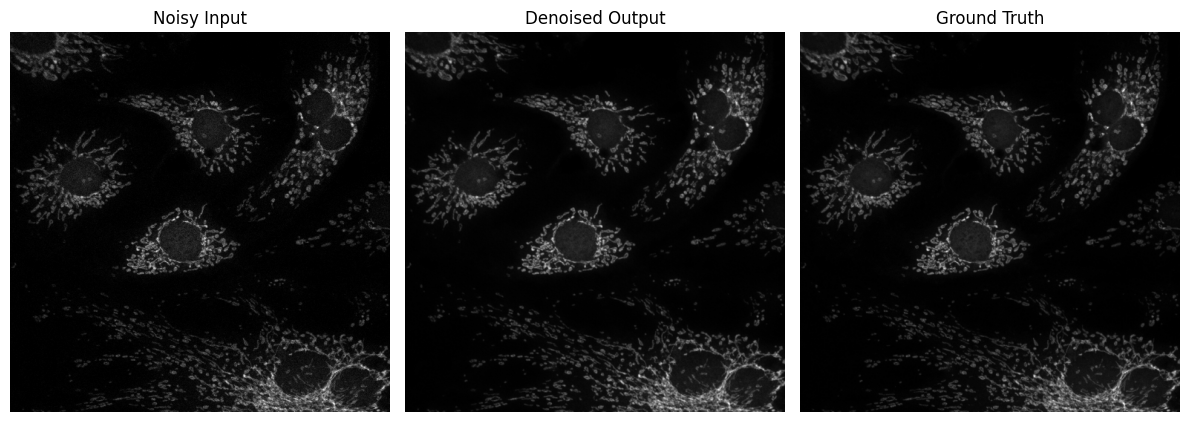

Saved new best model with validation loss: 34.6077
Epoch 01
Train Generator Loss: 37.1074
Train Discriminator Loss: 0.6862
Val Generator Loss: 34.6077 | Best Val Loss: 34.6077



Epoch 2/2 [Valid]: 100%|███████████████████████████████████████████████████████████| 2547/2547 [02:29<00:00, 17.04it/s]


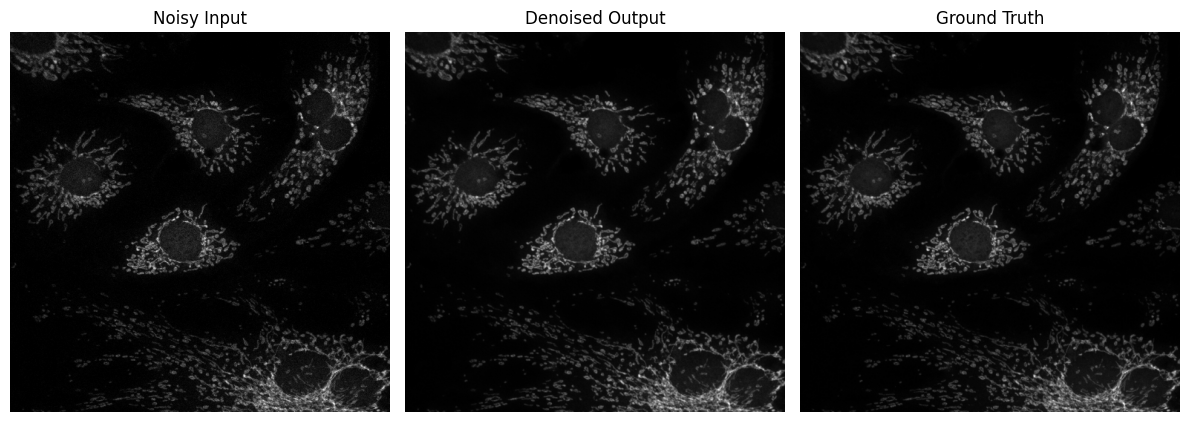

Saved new best model with validation loss: 34.1741
Epoch 02
Train Generator Loss: 37.0309
Train Discriminator Loss: 0.6988
Val Generator Loss: 34.1741 | Best Val Loss: 34.1741



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model setup
img_channel = 1  # Grayscale
width = 16
enc_blks = [2, 2, 4, 8]
middle_blk_num = 12
dec_blks = [2, 2, 2, 2]

generator = NAFNet(
    img_channel=img_channel,
    width=width,
    middle_blk_num=middle_blk_num,
    enc_blk_nums=enc_blks,
    dec_blk_nums=dec_blks
).to(device)

if os.path.exists(pretrained_path)==True: # Only if the path exists
    checkpoint = torch.load(pretrained_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    print(f"Loaded pretrained weights from {pretrained_path}")

discriminator = Discriminator(in_channels=1).to(device)

# Number of iterations
num_epochs = 2

# Optimizers and schedulers
T_max = max(1, int(num_epochs / 3))  # Ensure T_max is at least 1
g_optimizer = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
g_scheduler = CosineAnnealingLR(g_optimizer, T_max=T_max) # The learning rate will follow a cosine function.
d_scheduler = CosineAnnealingLR(d_optimizer, T_max=T_max) # The learning rate will follow a cosine function.

# Loss
criterion = CycleGANLoss(device, lambda_gan=1.0).to(device)

# Mixed precision
scaler_g = GradScaler('cuda')
scaler_d = GradScaler('cuda')

# Tracking
best_val_loss = float('inf')
train_g_losses = []
train_d_losses = []
val_g_losses = []

os.makedirs("training_visuals", exist_ok=True)

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    current_g_loss = 0.0
    current_d_loss = 0.0
    valid_batches = 0

    for noisy_img, clean_img in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
        noisy_img, clean_img = noisy_img.to(device), clean_img.to(device)

        if torch.isnan(noisy_img).any() or torch.isinf(noisy_img).any() or torch.isnan(clean_img).any() or torch.isinf(clean_img).any():
            print("⚠️ Warning: NaN or Inf detected in input images. Skipping batch.")
            continue

        # Train Discriminator
        d_optimizer.zero_grad()
        with autocast(device_type='cuda', enabled=True):
            fake_img = generator(noisy_img)
            fake_img = torch.clamp(fake_img, 0, 1)
            d_real = discriminator(clean_img)
            d_fake = discriminator(fake_img.detach())
            d_loss = criterion.forward_discriminator(d_real, d_fake)

        if torch.isnan(d_loss) or torch.isinf(d_loss):
            print("⚠️ Warning: NaN or Inf detected in discriminator loss. Skipping batch.")
            continue

        scaler_d.scale(d_loss).backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        scaler_d.step(d_optimizer)
        scaler_d.update()

        # Train Generator
        g_optimizer.zero_grad()
        with autocast(device_type='cuda', enabled=True):
            fake_img = generator(noisy_img)
            fake_img = torch.clamp(fake_img, 0, 1)
            d_fake = discriminator(fake_img)
            g_loss = criterion.forward_generator(fake_img, clean_img, d_fake)

        if torch.isnan(g_loss) or torch.isinf(g_loss):
            print("⚠️ Warning: NaN or Inf detected in generator loss. Skipping batch.")
            continue

        scaler_g.scale(g_loss).backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        scaler_g.step(g_optimizer)
        scaler_g.update()

        current_g_loss += g_loss.item()
        current_d_loss += d_loss.item()
        valid_batches += 1

    if valid_batches > 0:
        current_g_loss /= valid_batches
        current_d_loss /= valid_batches
    else:
        current_g_loss = float('inf')
        current_d_loss = float('inf')
        print("Warning: No valid batches processed in training.")

    # Validation
    generator.eval()
    discriminator.eval()
    current_val_g_loss = 0.0
    valid_val_batches = 0
    with torch.no_grad():
        with autocast(device_type='cuda', enabled=True):
            for val_input, val_target in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                val_input = val_input.to(device)
                val_target = val_target.to(device)
                val_output = generator(val_input)
                val_output = torch.clamp(val_output, 0, 1)
                d_fake_val = discriminator(val_output)
                g_loss = criterion.forward_generator(val_output, val_target, d_fake_val)
                if torch.isnan(g_loss) or torch.isinf(g_loss):
                    print("⚠️ Warning: NaN or Inf detected in validation loss. Skipping batch.")
                    continue
                current_val_g_loss += g_loss.item() * val_input.size(0)
                valid_val_batches += val_input.size(0)

            if valid_val_batches > 0:
                current_val_g_loss /= valid_val_batches
                if epoch % 1 == 0:
                    plot_images(val_input[0], val_output[0], val_target[0], epoch)
            else:
                current_val_g_loss = float('inf')
                print("Warning: No valid batches processed in validation.")

    train_g_losses.append(current_g_loss)
    train_d_losses.append(current_d_loss)
    val_g_losses.append(current_val_g_loss)

    if current_val_g_loss < best_val_loss and valid_val_batches > 0:
        best_val_loss = current_val_g_loss
        torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'g_optimizer_state_dict': g_optimizer.state_dict(),
            'd_optimizer_state_dict': d_optimizer.state_dict(),
            'val_loss': best_val_loss,
        }, checkpoint_path)
        print(f"Saved new best model with validation loss: {best_val_loss:.4f}")

    g_scheduler.step()
    d_scheduler.step()

    print(f'Epoch {epoch + 1:02d}')
    print(f'Train Generator Loss: {current_g_loss:.4f}')
    print(f'Train Discriminator Loss: {current_d_loss:.4f}')
    print(f'Val Generator Loss: {current_val_g_loss:.4f} | Best Val Loss: {best_val_loss:.4f}\n')

# Save losses
loss_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Generator Loss': train_g_losses,
    'Train Discriminator Loss': train_d_losses,
    'Val Generator Loss': val_g_losses
})
loss_df.to_csv('training_losses_NAFNet_GAN.csv', index=False)

# Final visualization
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

val_input, val_target = next(iter(val_loader))
val_input = val_input.to(device)
val_target = val_target.to(device)

with torch.no_grad():
    val_output = generator(val_input)

input_img = val_input[0].cpu()
pred_img = val_output[0].cpu()
target_img = val_target[0].cpu()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Image (Noisy)")
plt.imshow(input_img.squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Predicted Image (Denoised)")
plt.imshow(pred_img.squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Ground Truth (Clean)")
plt.imshow(target_img.squeeze(), cmap='gray')
plt.axis('off')
plt.savefig(os.path.join("training_visuals", "final_result.png"))
plt.close()

# To answer some questions:
### 1. Why did you choose this model as baseline?
The dataset of the challenge included different degrees of noise. Then, after a careful review of the state-of-the-art on denoising images through supervised models, we found that this one was our best bet.

### 2. Why make it a GAN?
The idea is naive, and it comes from the fact that the Pix2Pix model uses a U-Net as a generator. If Pix2Pix outperforms the U-Net, why should this be the exception to the rule?

### 3. Which is the main advantage of the GAN?
We can play with different loss functions, such as VGG16, that could not have been possible with the vanilla NafNet version.